In [52]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import notebook, tqdm
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import os
from utils.utils import *
from model.mscred import ConformerMSCRED

In [55]:
from model.conformer.model import Conformer

In [56]:
import random

seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Data

In [60]:
DATA_PATH = "data/path"
all_data = pd.read_csv(DATA_PATH).drop(columns=['time']).values
all_data = preprocessing.MinMaxScaler().fit_transform(all_data)
all_data = all_data[:13000]

In [61]:
train_data = all_data[:-3000]
test_data = all_data[-3000:]

Example plot of 10 first timeseries

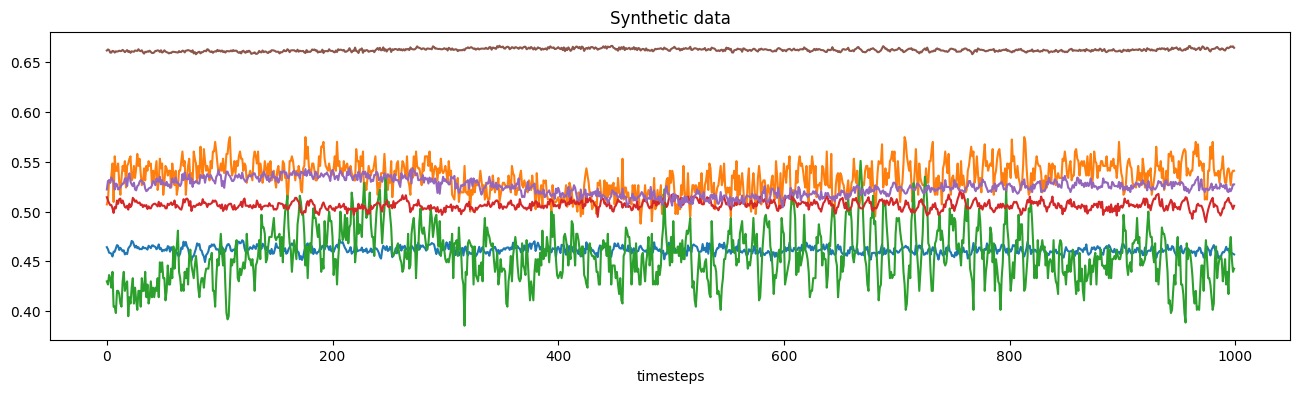

In [62]:
plt.figure(figsize=(16,4))
plt.plot(all_data[:1000,:10])
plt.title('Synthetic data')
plt.xlabel('timesteps')
plt.show()

In [63]:
def create_anomaly(data, start_index=100,  duration=60, series_num=0):
    base_value = data[start_index, series_num]
    data[start_index:start_index + duration, series_num] = base_value + np.random.normal(loc=0, scale=0.1, size=duration)

Creating anomalies with different durations

In [64]:
create_anomaly(test_data,  start_index=300,  duration=90, series_num=0)
create_anomaly(test_data,  start_index=2300,  duration=60, series_num=0)
create_anomaly(test_data,  start_index=1200,  duration=60, series_num=1)
create_anomaly(test_data,  start_index=2000,  duration=30, series_num=4)

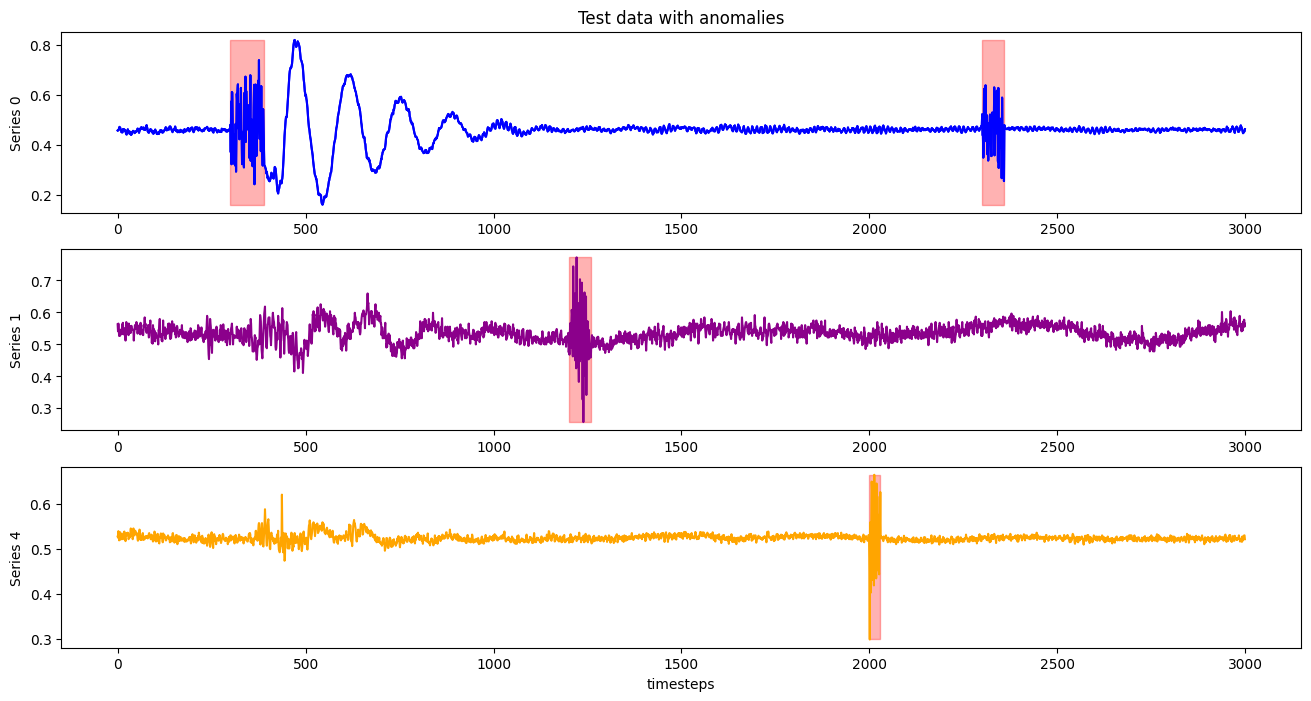

In [65]:
fig, ax = plt.subplots(3,1, figsize=(16,8))
ax[0].set_title('Test data with anomalies')
ax[0].plot(test_data[:,0], color='blue')
ax[0].fill_between(np.arange(300,300+90), y1=min(test_data[:,0]), y2=max(test_data[:,0]), color='red', alpha=0.3)
ax[0].plot(test_data[:,0], color='blue')
ax[0].set_ylabel('Series 0')
ax[0].fill_between(np.arange(2300,2300+60), y1=min(test_data[:,0]), y2=max(test_data[:,0]), color='red', alpha=0.3)
ax[1].plot(test_data[:,1], color='darkmagenta')
ax[1].fill_between(np.arange(1200,1200+60), y1=min(test_data[:,1]), y2=max(test_data[:,1]), color='red', alpha=0.3)
ax[1].set_ylabel('Series 1')
ax[2].plot(test_data[:,4], color='orange')
ax[2].fill_between(np.arange(2000,2000+30), y1=min(test_data[:,4]), y2=max(test_data[:,4]), color='red', alpha=0.3)
ax[2].set_ylabel('Series 4')
ax[2].set_xlabel('timesteps')
plt.show()

In [66]:
X, y = calculate_signature_matrix_dataset(train_data, lags=[10, 30, 60], stride=1, num_timesteps=5)

100%|██████████| 9941/9941 [00:08<00:00, 1193.04it/s]


In [67]:
X = X.transpose(0, 4, 1, 2, 3)

In [68]:
y = y.transpose(0,3,1,2)

In [69]:
X.shape

(9937, 3, 5, 6, 6)

In [70]:
y.shape

(9937, 3, 6, 6)

Plot layers of generated target signature matrix for fun

In [71]:
test_matrix = y[0]

In [72]:
test_matrix.shape

(3, 6, 6)

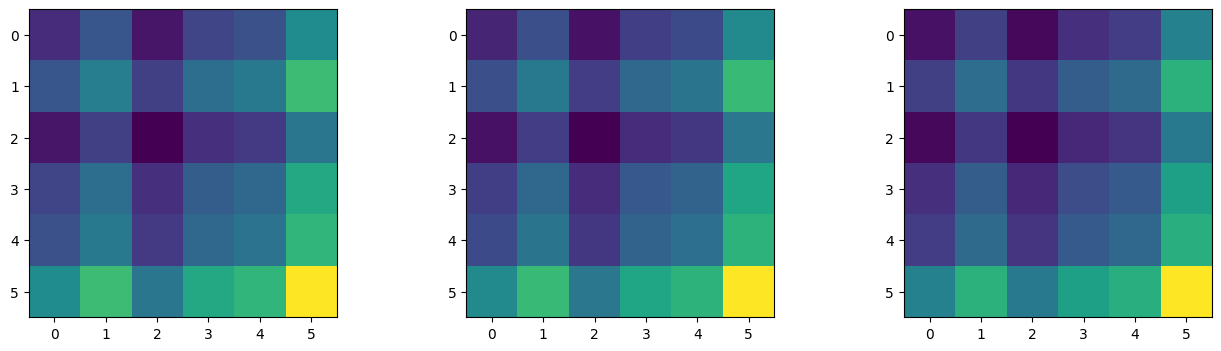

In [73]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].imshow(test_matrix[0,:,:])
ax[1].imshow(test_matrix[1,:,:])
ax[2].imshow(test_matrix[2,:,:])

In [74]:
train_size = int(0.7*len(X))

In [75]:
X_train = torch.Tensor(X[:train_size])
y_train = torch.Tensor(y[:train_size])
X_val = torch.Tensor(X[train_size:])
y_val = torch.Tensor(y[train_size:])

In [76]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16, shuffle=False)

# Train

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")
model = ConformerMSCRED(num_timesteps=5, attention=True, device=device).to(device)

Using device : cuda


In [78]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

468623


In [79]:
model.train()

ConformerMSCRED(
  (Conv1): Conv3d(3, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (Conformer1): Conformer(
    (encoder): ConformerEncoder(
      (conv_subsample): Conv2dSubampling(
        (sequential): Sequential(
          (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2))
          (1): ReLU()
          (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(2, 2))
          (3): ReLU()
        )
      )
      (input_projection): Sequential(
        (0): Linear(
          (linear): Linear(in_features=6, out_features=6, bias=True)
        )
        (1): Dropout(p=0.1, inplace=False)
      )
      (layers): ModuleList(
        (0-11): 12 x ConformerBlock(
          (sequential): Sequential(
            (0): ResidualConnectionModule(
              (module): FeedForwardModule(
                (sequential): Sequential(
                  (0): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
                  (1): Linear(
                    (linear): Linear(in_features=6

In [80]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [81]:
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.8)

In [82]:
criterion = nn.MSELoss()
num_epoch = 20

In [83]:
early_stop_rounds = 3
j = 0
best_loss = 1e10
epoch = 0
train_losses = []
val_losses = []
while j < early_stop_rounds and epoch < num_epoch:
    train_loss = 0.
    val_loss = 0.
    p_bar = tqdm(train_loader)
    for batch_x, batch_y in p_bar:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        train_loss += loss.item()
        p_bar.set_postfix({"loss":loss.item()})
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

        if val_loss < best_loss:
            best_loss = val_loss
            j = 0
            os.makedirs('./weights', exist_ok=True)
            torch.save(model.state_dict(), 'weights/mscred_weights.pt')
        else:
            j+=1
    print(f'epoch: {epoch} train loss: {train_loss/len(train_loader):0.4f}, validation loss:{val_loss/len(val_loader):0.4f}')
    epoch += 1
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()


100%|██████████| 435/435 [00:52<00:00,  8.25it/s, loss=0.0149]


epoch: 0 train loss: 0.1212, validation loss:0.0144


100%|██████████| 435/435 [00:53<00:00,  8.10it/s, loss=0.00658]


epoch: 1 train loss: 0.0098, validation loss:0.0072


100%|██████████| 435/435 [00:52<00:00,  8.32it/s, loss=0.0034]


epoch: 2 train loss: 0.0052, validation loss:0.0042


100%|██████████| 435/435 [00:52<00:00,  8.28it/s, loss=0.00339]


epoch: 3 train loss: 0.0033, validation loss:0.0030


100%|██████████| 435/435 [00:52<00:00,  8.28it/s, loss=0.00197]


epoch: 4 train loss: 0.0022, validation loss:0.0021


100%|██████████| 435/435 [00:53<00:00,  8.17it/s, loss=0.00119]


epoch: 5 train loss: 0.0016, validation loss:0.0018


100%|██████████| 435/435 [00:52<00:00,  8.25it/s, loss=0.000945]


epoch: 6 train loss: 0.0012, validation loss:0.0012


100%|██████████| 435/435 [00:52<00:00,  8.25it/s, loss=0.000565]


epoch: 7 train loss: 0.0010, validation loss:0.0011


100%|██████████| 435/435 [00:53<00:00,  8.20it/s, loss=0.000883]


epoch: 8 train loss: 0.0008, validation loss:0.0009


100%|██████████| 435/435 [00:52<00:00,  8.26it/s, loss=0.000382]


epoch: 9 train loss: 0.0007, validation loss:0.0008


100%|██████████| 435/435 [00:52<00:00,  8.24it/s, loss=0.000536]


epoch: 10 train loss: 0.0005, validation loss:0.0006


100%|██████████| 435/435 [00:52<00:00,  8.25it/s, loss=0.000689]


epoch: 11 train loss: 0.0005, validation loss:0.0007


100%|██████████| 435/435 [00:53<00:00,  8.08it/s, loss=0.000268]


epoch: 12 train loss: 0.0004, validation loss:0.0005


100%|██████████| 435/435 [00:53<00:00,  8.19it/s, loss=0.000252]


epoch: 13 train loss: 0.0004, validation loss:0.0005


100%|██████████| 435/435 [00:52<00:00,  8.31it/s, loss=0.000203]


epoch: 14 train loss: 0.0003, validation loss:0.0005


100%|██████████| 435/435 [00:52<00:00,  8.31it/s, loss=0.000165]


epoch: 15 train loss: 0.0003, validation loss:0.0005


100%|██████████| 435/435 [00:52<00:00,  8.29it/s, loss=0.000141]


epoch: 16 train loss: 0.0003, validation loss:0.0004


100%|██████████| 435/435 [00:52<00:00,  8.27it/s, loss=0.000168]


epoch: 17 train loss: 0.0002, validation loss:0.0004


100%|██████████| 435/435 [00:52<00:00,  8.30it/s, loss=0.000197]


epoch: 18 train loss: 0.0002, validation loss:0.0004


100%|██████████| 435/435 [00:52<00:00,  8.30it/s, loss=0.000135]


epoch: 19 train loss: 0.0002, validation loss:0.0003


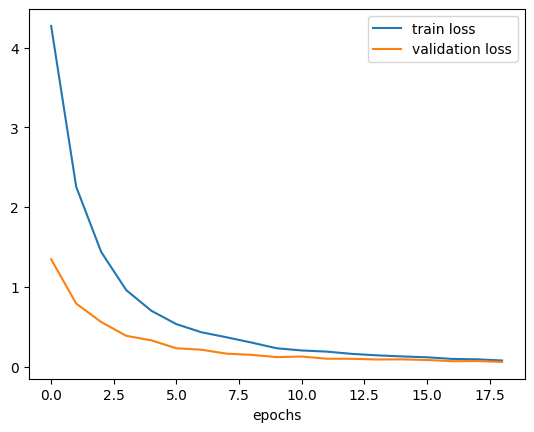

In [84]:
plt.plot(np.arange(epoch-1), train_losses[1:], label='train loss')
plt.plot(np.arange(epoch-1), val_losses[1:], label='validation loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Test

In [85]:
X_test, y_test = calculate_signature_matrix_dataset(test_data, lags=[10, 30, 60], stride=1, num_timesteps=5)

100%|██████████| 2941/2941 [00:00<00:00, 3082.77it/s]


In [86]:
X_test = torch.Tensor(X_test.transpose(0, 4, 1, 2, 3))
y_test = torch.Tensor(y_test.transpose(0, 3, 1, 2))
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256, shuffle=False)

In [87]:
model = ConformerMSCRED(num_timesteps=5, attention=True, device=device).to(device)
model.load_state_dict(torch.load('weights/mscred_weights.pt'))

<All keys matched successfully>

In [88]:
val_outputs = []
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        output = model(batch_x.to(device)).detach().cpu().numpy()
        val_outputs.append(output)
val_outputs = np.concatenate(val_outputs, axis=0)

In [89]:
y_val = y_val.numpy()

In [90]:
outputs = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x.to(device)).detach().cpu().numpy()
        outputs.append(output)
outputs = np.concatenate(outputs, axis=0)

In [91]:
y_test = y_test.cpu().numpy()

In [92]:
def calculate_mse(true, pred):
    residual_matrix = true - pred
    err = np.sum(residual_matrix**2, axis=1)
    err = np.sum(err, axis=1)
    err = np.sum(err, axis=1)/(pred.shape[1]*pred.shape[2]*pred.shape[3])
    return err, residual_matrix

In [93]:
val_mse, _ = calculate_mse(y_val, val_outputs)

mse on validation, very strange result

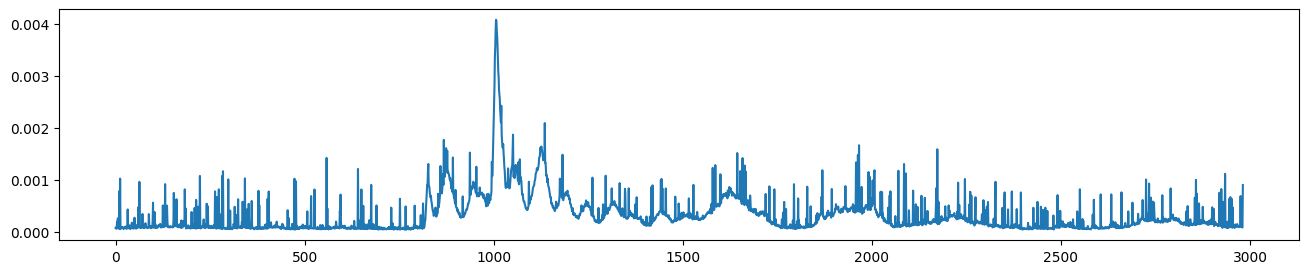

In [94]:
plt.figure(figsize=(16,3))
plt.plot(val_mse)

In [95]:
test_mse, _ = calculate_mse(y_test, outputs)

mse on test, model error doesn't show anything

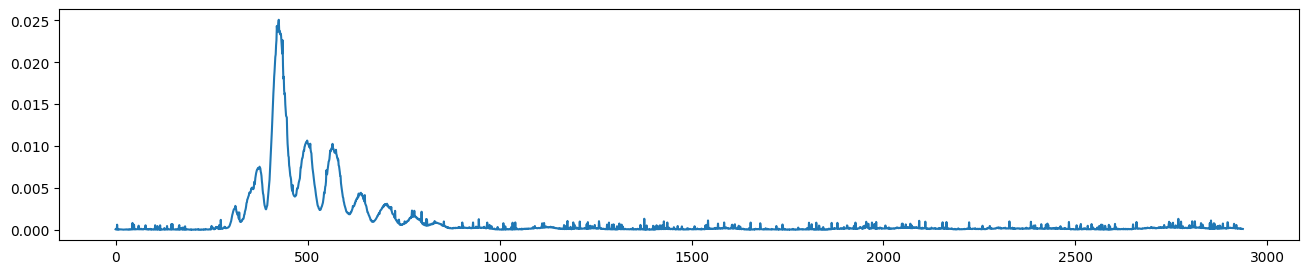

In [96]:
plt.figure(figsize=(16,3))
plt.plot(test_mse)

target matrix

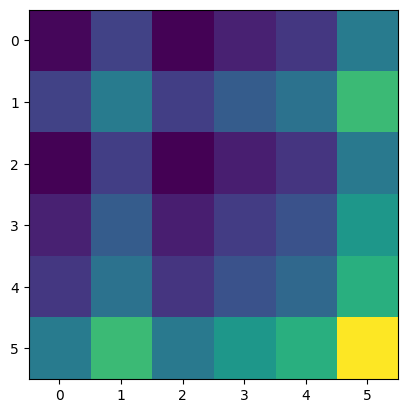

In [97]:
plt.imshow(y_test[0,1,:,:])

reconstructed matrix

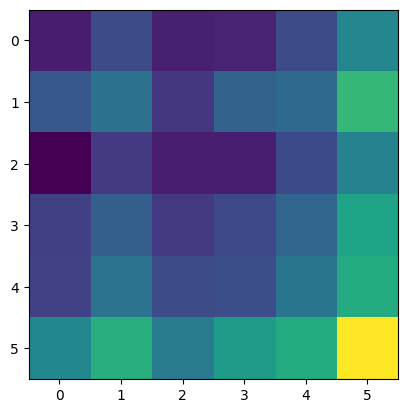

In [98]:
plt.imshow(outputs[0,1,:,:])

residual matrix / reconstruction is very poor residual matrix contains a lot of information

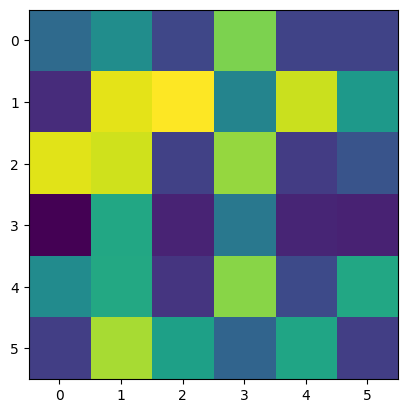

In [99]:
plt.imshow(y_test[0,1,:,:]-outputs[0,1,:,:])